# Testing a simple case with 6 nodes and 1 long range edge

This notebook is set up to test a very simple use case of `feems` with the hope that this will reveal some of the underlying mechanisms of the likelihood function (i.e., complex model so adding an edge may not increase log-likelihood), estimation of residuals, etc. 

In [88]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp
from scipy.stats.distributions import chi2

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import *

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulating use case



In [220]:
n_rows, n_columns = 2, 3
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(0,5)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 750
Simulating ~SNP 950


In [221]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

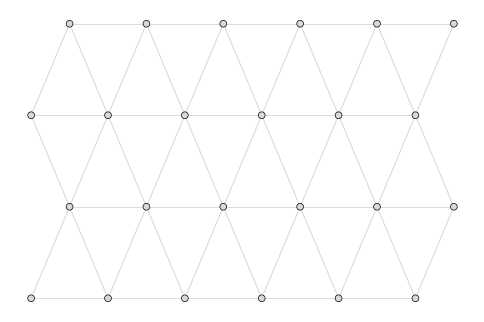

In [174]:
proj_test = ccrs.EquidistantConic(central_longitude=0.5, central_latitude=1.5)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph_def, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [222]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph_def, lamb_grid, n_folds=None if sp_Graph_def.n_observed_nodes < 10 else 10, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1

In [223]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=10, lamb=lamb_cv, plotFig=False)

constant-w/variance fit, converged in 161 iterations, train_loss=-6.4784745
lambda=0.1128838, alpha=0.1744226, converged in 13 iterations, train_loss=-13.4566890


In [224]:
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
edges_lr.append(list(x+1 for x in max_res_nodes[0]))
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))

In [225]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=None if sp_Graph_def.n_observed_nodes < 10 else 10, factr=1e10)
lamb_cv_lr = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1

In [226]:
sp_Graph.fit(lamb=lamb_cv_lr)

constant-w/variance fit, converged in 113 iterations, train_loss=-13.5614411
lambda=0.0061585, alpha=0.6973877, converged in 16 iterations, train_loss=-26.2369077


In [227]:
obj = Objective(sp_Graph_def)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()
obj._comp_inv_lap()
obj_lr = Objective(sp_Graph)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
obj_lr._comp_inv_lap()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better by %.2f units"%(-2*(obj_lr.neg_log_lik() - obj.neg_log_lik())))

Model with long-range edges fits better by 19.80 units


In [212]:
chi2.sf(60.94,1)

5.884106115937858e-15

### Initial takeaways:  
1. With simple graph, the `max_res_nodes` detects the correct long range edge in the top 3 everytime (it includes already connected pairs of nodes, as well -- super, super unlikely in empirical data)   
2. When adding the correct edge, there is a significant increase in the log-likelihood of the data (no other edge gives such a significant increase - nearby edge gives $p<0.05$, but not $p<1e-6$)    
    a. Similar results for 4x6 graph too - the correct long range edge gives largest increase in log-likelihood, but other top (but not correct) long range edges also give a smaller log-lik value but still significant improvement

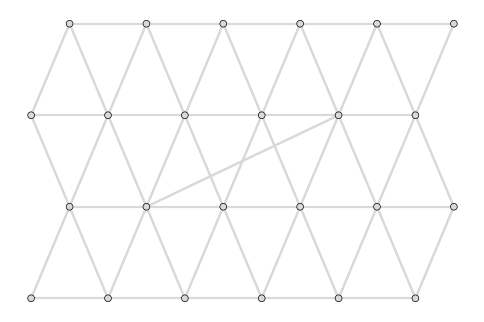

In [213]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=1.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

### Comparing the attributes of the two objects

Below, I examine the attributes of the graph objects - with and without the long range edge (look at the observed covariance, fitted covariance, residual, pseudo Laplacian, etc.)

Do 5 reps of each parameter choice (2x3, 4x6):   
The corresponding *fit_cov* element decreases to $\approx 0$ on adding the long range edge. Some adjoining edges increase, some decrease...(default cov value is high and negative, long range cov is small and positive)  
The corresponding *pseudo inverse Laplacian* element increases (when it should decrease) - intuition: expected commute time between nodes (every other element decreases tho...random chance?)

Interestingly, differences in fit_cov matrices is *almost* equal to differences in pseudo inverse Laplacians (diagonals are offset by the same value) - carry same information?

In [228]:
fit_cov, _, emp_cov = comp_mats(obj)
fit_cov_lr, _, emp_cov_lr = comp_mats(obj_lr)

In [229]:
np.set_printoptions(precision=3) 
print(fit_cov[lrn[0][0], lrn[0][1]])
print(fit_cov_lr[lrn[0][0], lrn[0][1]])

-0.03870386260073433
-0.026161697632699682


In [230]:
diff_mats = fit_cov - fit_cov_lr - (obj.Linv - obj_lr.Linv)
np.sum(np.abs(diff_mats - np.diag(np.diagonal(diff_mats)))>1e-15)

0

In [51]:
print(emp_cov)

[[ 0.254 -0.018 -0.07  -0.042 -0.12  -0.003]
 [-0.018  0.317 -0.056 -0.02  -0.074 -0.149]
 [-0.07  -0.056  0.346 -0.168 -0.042 -0.01 ]
 [-0.042 -0.02  -0.168  0.406 -0.05  -0.126]
 [-0.12  -0.074 -0.042 -0.05   0.39  -0.104]
 [-0.003 -0.149 -0.01  -0.126 -0.104  0.393]]


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [231]:
#print(obj.Linv)
print(obj.Linv[lrn[0][0], lrn[0][1]])
print(obj_lr.Linv[lrn[0][0], lrn[0][1]])
(obj.Linv - obj_lr.Linv)[lrn[0][0], lrn[0][1]]

0.12796280406593233
0.14050496903396698


-0.012542164968034647

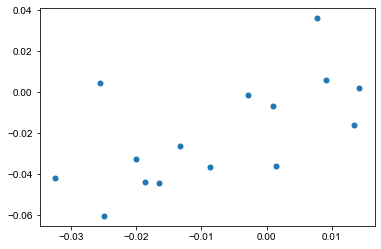

In [34]:
plt.plot(fit_cov[np.tril_indices(6,k=-1)], fit_cov_lr[np.tril_indices(6,k=-1)], 'o', markersize=5)
plt.plot(fit_cov[0,5], fit_cov_lr[0,5], color='black', markersize=10)

In [32]:
?plt.plot

Signature: plt.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y,